# Regularization

You will learn to: Use regularization in your deep learning models.

In [318]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import scipy.io

from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative

In [319]:
def load_data():
    data = scipy.io.loadmat('data/data.mat')
    train_X = data['X'].T # (2, 211) 
    train_Y = data['y'].T # (1, 211)

    test_X = data['Xval'].T # (2, 200)
    test_Y = data['yval'].T # (1, 200)
    
    plt.scatter(data['X'][:, 0], data['X'][:, 1], marker='o', c=data['y'], s=40, cmap=plt.cm.Spectral)
    
    return train_X, train_Y, test_X, test_Y

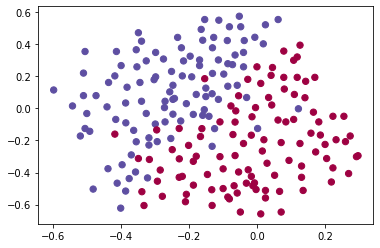

In [320]:
train_X, train_Y, test_X, test_Y = load_data()

# 1 - Build 4-layer NN

In [321]:
def forward_propagation (X, params):
    # 3 Layers (X -> A1(relu) -> A2(relu) -> A3(sigmoid))
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    
    b1 = params['b1']
    b2 = params['b2']
    b3 = params['b3']
    
    # Layer 1
    A1 = ReLU(np.dot(W1.T, X) + b1)
    # Layer 2
    A2 = ReLU(np.dot(W2.T, A1) + b2)
    # Layer 3
    A3 = sigmoid(np.dot(W3.T, A2) + b3)

    A = {
        'A0': X,
        'A1': A1,
        'A2': A2,
        'A3': A3
    }

    return A

# ===== Dropout =====
def forward_propagation_with_dropout (X, params, keep_prob):
    W1, W2, W3 = params['W1'], params['W2'], params['W3']
    b1, b2, b3 = params['b1'], params['b2'], params['b3']
    # Layer 1
    A1 = ReLU(np.dot(W1.T, X) + b1)
    
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = D1 < keep_prob
    A1 = A1 * D1
    A1 = A1 / keep_prob
    # Layer 2
    A2 = ReLU(np.dot(W2.T, A1) + b2)
    
    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = D2 < keep_prob
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    # Layer 3
    # 最后一层不需要处理
    A3 = sigmoid(np.dot(W3.T, A2) + b3)
    
    A = {
        'A0': X,
        'A1': A1,
        'A2': A2,
        'A3': A3,
        'D1': D1, # 需要删减的节点
        'D2': D2 # 需要删减的节点
    }

    return A
    

def cost_function (A, y):
    A3 = A['A3']
    m = y.shape[1]
    loss = -y * np.log(A3) - (1 - y) * np.log(1 - A3)
    J = (1 / m) * np.sum(loss)

    return J

# ===== L2 regularization =====
def cost_function_with_regularization (A, y, params, lambd):
    J = cost_function(A, y)
    m = y.shape[1]
    # ===== L2 regularization =====
    # (lambda / 2m) * np.sum(weights^2)
    W1, W2, W3 = params['W1'], params['W2'], params['W3']
    L2_regularization_cost = lambd * (1 / 2 * m) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W2)))

    return J + L2_regularization_cost


def backward_propagation (A, y, params):
    m = y.shape[1]
    # dJ_dZ3 = A3 - y
    dJ_dZ3 = A['A3'] - y
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T)
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # dJ_dZ2
    dJ_dZ2 = np.dot(params['W3'], dJ_dZ3) * ReLU_derivative(A['A2'])
    dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T)
    dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True)
    
    # dJ_dZ1
    dJ_dZ1 = np.dot(params['W2'], dJ_dZ2) * ReLU_derivative(A['A1'])
    dJ_dW1 = (1 / m) * np.dot(A['A0'], dJ_dZ1.T)
    dJ_db1 = (1 / m) * np.sum(dJ_dZ1, axis = 1, keepdims = True)
    
    grads = {
        'dJ_dW3': dJ_dW3,
        'dJ_db3': dJ_db3,
        'dJ_dW2': dJ_dW2,
        'dJ_db2': dJ_db2,
        'dJ_dW1': dJ_dW1,
        'dJ_db1': dJ_db1
    }
    
    return grads

# ===== L2 regularization =====
def backward_propagation_with_regularization (A, y, params, lambd):
    # dJ_dW = dJ_dW + (lambd / m) * W 
    m = y.shape[1]
    # dJ_dZ3 = A3 - y
    dJ_dZ3 = A['A3'] - y
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T) + (lambd / m) * params['W3'] # dJ_dW = dJ_dW + (lambd / m) * W 
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # dJ_dZ2
    dJ_dZ2 = np.dot(params['W3'], dJ_dZ3) * ReLU_derivative(A['A2'])
    dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T) + (lambd / m) * params['W2'] # dJ_dW = dJ_dW + (lambd / m) * W 
    dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True)
    
    # dJ_dZ1
    dJ_dZ1 = np.dot(params['W2'], dJ_dZ2) * ReLU_derivative(A['A1'])
    dJ_dW1 = (1 / m) * np.dot(A['A0'], dJ_dZ1.T) + (lambd / m) * params['W1'] # dJ_dW = dJ_dW + (lambd / m) * W 
    dJ_db1 = (1 / m) * np.sum(dJ_dZ1, axis = 1, keepdims = True)
    
    grads = {
        'dJ_dW3': dJ_dW3,
        'dJ_db3': dJ_db3,
        'dJ_dW2': dJ_dW2,
        'dJ_db2': dJ_db2,
        'dJ_dW1': dJ_dW1,
        'dJ_db1': dJ_db1
    }
    
    return grads

# ===== dropout =====
def backward_propagation_with_dropout (A, y, params, keep_prob):
    D1 = A['D1']
    D2 = A['D2']
    
    m = y.shape[1]
    # ===== dJ_dZ3 = A3 - y =====
    # 最后一层不处理
    dJ_dZ3 = A['A3'] - y
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T)
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # ===== dJ_dZ2 =====
    # 原来: dJ_dZ2 = np.dot(params['W3'], dJ_dZ3) * ReLU_derivative(A['A2'])
    
    # -------- start -------- 
    dJ_dA2 = np.dot(params['W3'], dJ_dZ3) # 1. dJ_dA2
    dJ_dA2 = dJ_dA2 * D2 # 2. dJ_dA2 * D2 只处理保留的结点
    dJ_dA2 = dJ_dA2 / keep_prob # 3. dJ_dA2 / keep_prob 值伸缩   
    dJ_dZ2 = dJ_dA2* ReLU_derivative(A['A2']) # 4. dJ_dZ2
    # -------- end --------
    
    dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T)
    dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True)
    

    # ===== dJ_dZ1 =====
    # 原来 dJ_dZ1 = np.dot(params['W2'], dJ_dZ2) * ReLU_derivative(A['A1'])
    
    # -------- start --------
    dJ_dA1 = np.dot(params['W2'], dJ_dZ2)
    dJ_dA1 = dJ_dA1 * D1
    dJ_dA1 = dJ_dA1 / keep_prob
    dJ_dZ1 = dJ_dA1 * ReLU_derivative(A['A1'])
    # -------- end --------

    dJ_dW1 = (1 / m) * np.dot(A['A0'], dJ_dZ1.T)
    dJ_db1 = (1 / m) * np.sum(dJ_dZ1, axis = 1, keepdims = True)
    
    grads = {
        'dJ_dW3': dJ_dW3,
        'dJ_db3': dJ_db3,
        'dJ_dW2': dJ_dW2,
        'dJ_db2': dJ_db2,
        'dJ_dW1': dJ_dW1,
        'dJ_db1': dJ_db1
    }
    
    return grads
   
    
def update_derivatives (params, grads, alpha, L_len):
    for l in range(1, L_len):
        params['W' + str(l)] -= alpha * grads['dJ_dW' + str(l)]
        params['b' + str(l)] -= alpha * grads['dJ_db'+ str(l)]
    
    return params

def plot_cost (J_arr, alpha):
    plt.plot(J_arr)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(alpha))
    plt.show()
    
    
def plot_decision_boundary (model, X, y):
    axes = plt.gca()
    axes.set_xlim([-0.75,0.40])
    axes.set_ylim([-0.75,0.65])

    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec (params, X):
    A= forward_propagation(X, params)
    A3 = A['A3']
    return np.round(A3)

def predict (X, y, params, text = '精确度'):
    A = forward_propagation(X, params)
    A3 = A['A3']
    m = A3.shape[1]
    
    y_predict = np.round(A3)
    
    # 精确度预测
    accuracy = (1 - np.sum(abs(y_predict - y)) / m) * 100
    print(text)
    print("===== Accuracy: " + str(accuracy) + '% =====')
    
    # 绘图
    plot_decision_boundary(lambda x: predict_dec(params, x.T), X, y)

In [323]:
class NN_Model ():
    def __init__(self, X, y, Layers):
        self.X = X
        self.y = y
        
        self.Layers = Layers
        self.L_len = len(Layers)
        self.m = X.shape[1]
        
        # hyperparameters:
        self.alpha = 0.3
        self.iterations = 30000
    
    def init_parameters_he (self):
        print('===== He initialization =====')
        parameters = {}
        for i in range(1, len(self.Layers)):
            # 缩放因子
            # he = np.sqrt(2. / self.Layers[i - 1])
            he = 1
            parameters['W' + str(i)] = np.random.randn(self.Layers[i - 1], self.Layers[i]) * he
            parameters['b' + str(i)] = np.zeros(shape = (self.Layers[i], 1))
        return parameters

    def training (self):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        
        J_arr = []
        
        # 1. init parameters
        params = self.init_parameters_he()


        for i in range(self.iterations):
            # 2. Forward propagation
            A = forward_propagation(X, params)

            # 3. Loss
            if i % 1000 == 0:
                J = cost_function(A, y)
                J_arr.append(J)

            # 4. backward_propagation
            grads = backward_propagation (A, y, params)

            # 5. update_derivatives
            params = update_derivatives (params, grads, alpha, L_len)
        
        # plot cost
        plot_cost (J_arr, alpha)
        
        # return Weights and bias
        return params
    
    def training_regularization (self, lambd):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        
        J_arr = []
        params = self.init_parameters_he()
        for i in range(self.iterations):
            A = forward_propagation(X, params)
            if i % 1000 == 0:
                # ===== cost_function_with_regularization =====
                J = cost_function_with_regularization(A, y, params, lambd)
                J_arr.append(J)

            # ===== backward_propagation_with_regularization =====
            grads = backward_propagation_with_regularization (A, y, params, lambd)
            params = update_derivatives (params, grads, alpha, L_len)
        print('===== L2 initialization =====')
        
        # plot cost
        plot_cost (J_arr, alpha)
        return params
    
    def training_dropout (self, keep_prob):
        X, y = self.X, self.y
        L_len, alpha = self.L_len, self.alpha
        
        J_arr = []
        params = self.init_parameters_he()
        for i in range(self.iterations):
            # 特殊处理 I
            A = forward_propagation_with_dropout(X, params, keep_prob)
            
            if i % 1000 == 0:
                J = cost_function(A, y)
                J_arr.append(J)
                
            # 特殊处理 II
            grads = backward_propagation_with_dropout (A, y, params, keep_prob)
            params = update_derivatives (params, grads, alpha, L_len)
        
        plot_cost (J_arr, alpha)
        return params

# 2 - Non-regularized model

===== He initialization =====


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply


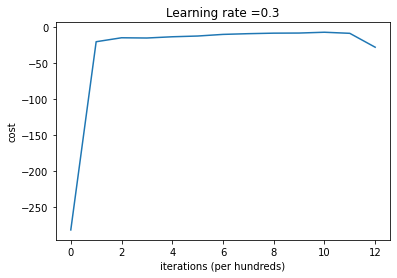

Non-regularization training set
===== Accuracy: 98.10426540284361% =====


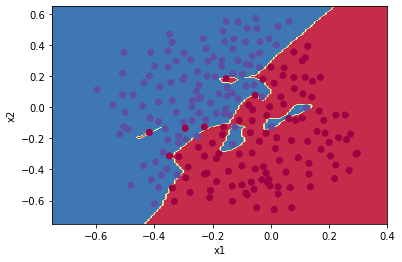

Non-regularization test set
===== Accuracy: 92.0% =====


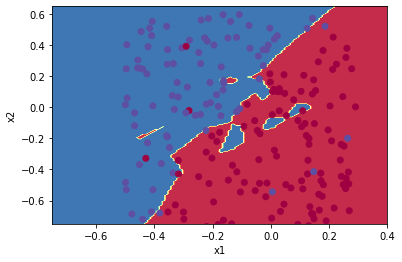

In [324]:
Layers = [train_X.shape[0], 20, 3, 1]

NN_he = NN_Model(train_X, train_Y, Layers)
params_he = NN_he.training()

# training set
predict(train_X, train_Y, params_he, 'Non-regularization training set')
# testing set
predict(test_X, test_Y, params_he, 'Non-regularization test set')

# 3 - L2 Regularization

## 3 - 1 cost function

$J = 1/m * \sum(loss) + \frac{\lambda}{2m} * \sum(weights^2)$

```python
def cost_function_with_regularization (A, y, params, lambd):
    A3 = A['A3']
    m = y.shape[1]
    loss = -y * np.log(A3) - (1 - y) * np.log(1 - A3)
    J = (1. / m) * np.nansum(loss)
    # ===== L2 regularization =====
    # (lambda / 2m) * np.sum(weights^2)
    W1, W2, W3 = params['W1'], params['W2'], params['W3']
    L2_regularization_cost = lambd * (1 / 2 * m) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W2)))

    return J + L2_regularization_cost
```

## 3 - 2 gradient descent
$dJ/dW = dJ/dW + \frac{\lambda * W}{m}$

```python
def backward_propagation_with_regularization (A, y, params, lambd):
    m = y.shape[1]
    dJ_dZ3 = A['A3'] - y
    # dJ_dW = dJ_dW + (lambd / m) * W 
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T) + (lambd / m) * params['W3']
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # dJ_dZ2
    ...
```

===== He initialization =====
===== L2 initialization =====


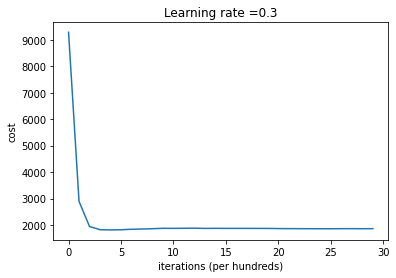

L2 regularization training set
===== Accuracy: 92.41706161137441% =====


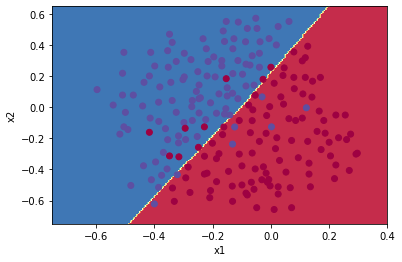

L2 regularization test set
===== Accuracy: 93.5% =====


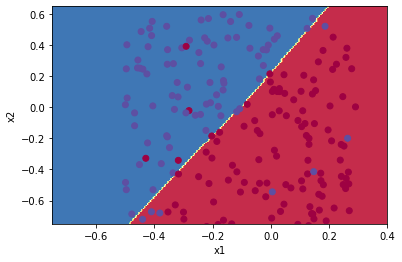

In [325]:
Layers = [train_X.shape[0], 20, 3, 1]

NN_he = NN_Model(train_X, train_Y, Layers)
params_he = NN_he.training_regularization(0.7)

# training set
predict(train_X, train_Y, params_he, 'L2 regularization training set')
# testing set
predict(test_X, test_Y, params_he, 'L2 regularization test set')

# 4 - Dropout

It randomly shuts down some neurons in each iteration.

# 4.1 - Forward propagation with dropout

1. A1 (m * n matrix)
2. D1 (m * n matrix) 根据A1的shape尺寸, 建立一个从0-1的随机矩阵
3. D1 = D1 < keep_prob 保留一部分内容
4. A1 = A1 * D1 保存进保留的节点
5. A1 = A1 / keep_prob 拉伸值

```python
def forward_propagation_with_dropout (X, params, keep_prob):
    W1, W2, W3 = params['W1'], params['W2'], params['W3']
    b1, b2, b3 = params['b1'], params['b2'], params['b3']
    # Layer 1
    # 1. A1
    A1 = ReLU(np.dot(W1.T, X) + b1)
    # 2. D1 (m * n matrix) 根据A1的shape尺寸, 建立一个从0-1的随机矩阵
    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    # 3. D1 = D1 < keep_prob 保留一部分内容
    D1 = D1 < keep_prob
    # 4. A1 = A1 * D1 保存进保留的节点
    A1 = A1 * D1
    # A1 = A1 / keep_prob 拉伸值
    A1 = A1 / keep_prob
    
    # Layer 2
    A2 = ReLU(np.dot(W2.T, A1) + b2)
    ... 同A1处理
    
    # Layer 3 最后一层不需要处理
    A3 = sigmoid(np.dot(W3.T, A2) + b3)
    ...
```

In [326]:
# 例子
# 1. A1
A1 = np.array([
    [1, 2, 3],
    [4, 5, 6]
])
m, n = A1.shape

# 2. D1
D1 = np.random.rand(m, n)
print('==== 2. D1 =====')
print(D1)

# 3. D1 = D1 < keep_prob, 保留60%的节点
keep_prob = 0.8
D1 = D1 < keep_prob
print('====  3. 保留节点D1 ====')
print(D1)

# 4. A1 = A1 * D1
A1 = A1 * D1
print('====  4. A剩下保留的节点 ====')
print(A1)

# 5. A1 = A1 / keep_prob 原来是9个结点有值, 为了下一个值相似, 将保留的值拉伸至 1/keep_prob 倍
A1 = A1 / keep_prob
print('====  5. A值拉伸 ====')
print(A1)

==== 2. D1 =====
[[0.36673336 0.34967649 0.0053029 ]
 [0.66649671 0.70231138 0.51689637]]
====  3. 保留节点D1 ====
[[ True  True  True]
 [ True  True  True]]
====  4. A剩下保留的节点 ====
[[1 2 3]
 [4 5 6]]
====  5. A值拉伸 ====
[[1.25 2.5  3.75]
 [5.   6.25 7.5 ]]


# 4.2 - backward propagation with dropout

1. dJ_dA2: np.dot(params['W3'], dJ_dZ3)
2. 只保留某些nodes: dJ_dA2 * D2
3. 保留下nodes扩张值: dJ_dA2 / keep_prob
4. dJ_dZ2 = dJ_dA2 * (A2)'

```python
def backward_propagation_with_dropout (A, y, params, keep_prob):
    D1, D2 = A['D1'], A['D2']
    m = y.shape[1]
    # ===== dJ_dZ3 = A3 - y 最后一层不处理 =====
    dJ_dZ3 = A['A3'] - y
    dJ_dW3 = (1 / m) * np.dot(A['A2'], dJ_dZ3.T)
    dJ_db3 = (1 / m) * np.sum(dJ_dZ3, axis = 1, keepdims = True)
    
    # ===== dJ_dZ2 =====
    # 原来: dJ_dZ2 = np.dot(params['W3'], dJ_dZ3) * ReLU_derivative(A['A2'])
    
    # -------- start -------- 
    dJ_dA2 = np.dot(params['W3'], dJ_dZ3) # 1. dJ_dA2
    dJ_dA2 = dJ_dA2 * D2 # 2. dJ_dA2 * D2 只处理保留的结点
    dJ_dA2 = dJ_dA2 / keep_prob # 3. dJ_dA2 / keep_prob 值伸缩   
    dJ_dZ2 = dJ_dA2* ReLU_derivative(A['A2']) # 4. dJ_dZ2
    # -------- end --------
    
    dJ_dW2 = (1 / m) * np.dot(A['A1'], dJ_dZ2.T)
    dJ_db2 = (1 / m) * np.sum(dJ_dZ2, axis = 1, keepdims = True)
    
    ... 同上面处理
    return grads
   
```

===== He initialization =====


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in multiply


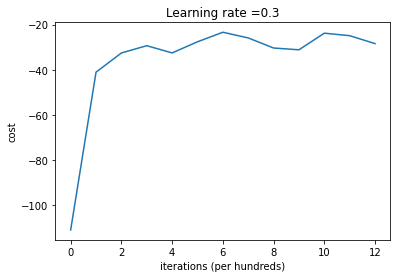

Dropout training set
===== Accuracy: 95.73459715639811% =====


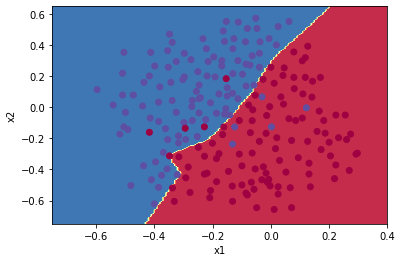

Dropout test set
===== Accuracy: 93.5% =====


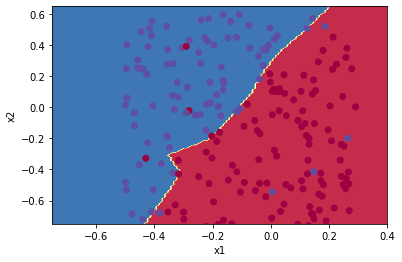

In [327]:
Layers = [train_X.shape[0], 20, 3, 1]

NN_he = NN_Model(train_X, train_Y, Layers)
params_he = NN_he.training_dropout(0.86) # keep_prob = 0.86

# training set
predict(train_X, train_Y, params_he, 'Dropout training set')
# testing set
predict(test_X, test_Y, params_he, 'Dropout test set')

# 5 - Conclusions

| type | training accuracy | test accuracy |
| :--- | :----: | ----: |
| without regularization | 98.10% | 92% |
| L2-regularization   | 92.41%     |  93.5%   |
| dropout   | 95.73%      | 93.5%     | 

- Regularization will help you reduce **overfitting**.
- Regularization will drive your **weights to lower values**.
- **L2 regularization and Dropout** are two very effective regularization techniques.